# Árboles de Clasificación desde 0 en Python!

En este notebook se mostrará un código para ejecutar un árbol de clasificación. La idea del código en general esta basada en https://github.com/Suji04/ML_from_Scratch/blob/master/decision%20tree%20classification.ipynb. No obstante, el código desarrollado aquí esta adaptado para tomar variables independiente cualitativas, agrega el podado y hace la gráfica del árbol.

Primero importaremos algunos paquetes que son de suma utilidad. Y además, se definirá la base de datos

In [144]:
#Paquetes
import pandas as pd #Importa el formato de Dataframes Pandas (notado como pd)
import numpy as np  #Algunas operaciones de listas, números, etc (notado como np)
from fractions import Fraction # Herramienta de fracciones para tener una exactitud en las proporciones
import graphviz # Ayuda a graficar los árboles


#Base de datos (importada de gitHub)
url = "https://raw.githubusercontent.com/3vargas5/tesisArbolesClasificacion/main/basesdeDatos/baseDatosIris.csv"
datos = pd.read_csv(url)
#Removemos la columna "Id"
datos.pop("Id")
#Visualizamos la tabla
datos.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Para comenzar, se creará el formato de los nodos para que guarden la información conseguida.

In [2]:
class nodo:
    def __init__(
        self,mejor_variable = None,
        threshold = None,
        hoja_izq = None,
        hoja_der = None,
        etiqueta = None,
        impureza = None,
        estadoNodo = None,
        data = None):
      self.mejor_variable = mejor_variable  #Guarda la mejor variable juzgada por la función de disminución de impureza
      self.threshold = threshold            #Guarda el mejor umbral de la variable por la función de disminución de impureza
      self.hoja_izq = hoja_izq              #Guarda el nodo izquierdo resultado de una división
      self.hoja_der = hoja_der              #Guarda el nodo derecho resultado de una división
      self.etiqueta = etiqueta              #Guarda la clase representante del nodo (tomando la clase de mayor proporción)
      self.impureza = impureza              #Guarda la reducción de la impureza de la variable y el umbral.
      self.estadoNodo = estadoNodo          #Guarda el estado del nodo (hoja, no terminal)
      self.data = data                      #Guarda un dataframe con los datos que residen en el nodo

Definimos la función de impureza: En este caso se define Gini y Entropia, se puede tomar cualquiera.

In [3]:
def funcImpGini(datos) -> float:
    y = datos[datos.columns[-1]]
    proporciones = y.value_counts(normalize=True)
    suma = 0
    for i in proporciones:
      suma += i**2
    return 1-suma

def funcImpEntropia(datos) -> float:
    y = datos[datos.columns[-1]]
    proporciones = y.value_counts(normalize=True)
    suma = 0
    for i in proporciones:
      if i == 0:
        continue
      else:
        suma += i*np.log2(i)
    return -suma

Se define ahora la función de reducción de impureza:

In [4]:
def funcReducImp(nodo,nodo_izq,nodo_der,funcImp = funcImpGini) -> float: #Por defecto la funcion de impureza Gini
    tamano_nodo, tamano_nodo_izq, tamano_nodo_der = nodo.shape[0],nodo_izq.shape[0],nodo_der.shape[0]
    impureza_nodo = funcImp(nodo)
    impureza_nodo_izq, impureza_nodo_der = funcImp(nodo_izq), funcImp(nodo_der)
    prop_nodo_izq, prop_nodo_der = tamano_nodo_izq / tamano_nodo, tamano_nodo_der / tamano_nodo
    return impureza_nodo - prop_nodo_izq * impureza_nodo_izq - prop_nodo_der * impureza_nodo_der
    

Ahora bien, se generará un conjunto de umbrales para cada variable con el fin de ser juzgados por la función de impureza y así tomar la mejor variable y umbral para un nodo. El resultado será un diccionario que almacena los datos de la mejor variable, junto a su umbral y los datos de sus hojas (para usar el modelo estos mismo datos se guardan en la clase Nodo)

In [5]:
def mejor_variable_nodo(datos,funcImp = funcImpGini):
    dicMejor = {} #Aqui se guarda la información de la mejor_variable
    max = 0  # Se toma un valor base
    nombre_variables = datos.columns[:-1]
    for variable in nombre_variables:
        datos_variable = datos[variable]
        datos_unicos_variable = np.unique(datos_variable) #la función toma los datos únicos y los organiza de menor a mayor
        if datos_variable.dtype.kind in 'iufc': #En caso de que la variable sea numérica o booleana
            puntos_medios = [(datos_unicos_variable[i]+datos_unicos_variable[i+1])/2 for i in range(len(datos_unicos_variable)-1)] #Se toman los puntos medios
            for punto in puntos_medios:
                nodo_izq, nodo_der = datos[datos_variable <= punto], datos[datos_variable > punto]
                redImpureza = funcReducImp(datos,nodo_izq,nodo_der,funcImp)
                if redImpureza > max:
                    max = redImpureza
                    threshold = punto
                    nombre_mejorVariable = variable
                    hoja_izq = nodo_izq
                    hoja_der = nodo_der
        else: #En caso de que la variable sea cualitativa
            for cualidad in datos_unicos_variable:
                nodo_izq, nodo_der = datos[datos_variable == cualidad], datos[datos_variable != cualidad]
                redImpureza = funcReducImp(datos,nodo_izq,nodo_der,funcImp)
                if redImpureza > max:
                    max = redImpureza
                    threshold = cualidad
                    nombre_mejorVariable = variable
                    hoja_izq = nodo_izq
                    hoja_der = nodo_der
    dicMejor["Variable"] = nombre_mejorVariable
    dicMejor["Threshold"] = threshold
    dicMejor["valorImpureza"] = max
    dicMejor["nodoIzq"] = hoja_izq
    dicMejor["nodoDer"] = hoja_der
    return dicMejor
            

Ahora bien, corriendo el código se puede encontrar los datos de la primera división óptima.

In [6]:
mejor_variable_nodo(datos)

{'Threshold': 2.45,
 'Variable': 'PetalLengthCm',
 'nodoDer':      SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm          Species
 50             7.0           3.2            4.7           1.4  Iris-versicolor
 51             6.4           3.2            4.5           1.5  Iris-versicolor
 52             6.9           3.1            4.9           1.5  Iris-versicolor
 53             5.5           2.3            4.0           1.3  Iris-versicolor
 54             6.5           2.8            4.6           1.5  Iris-versicolor
 ..             ...           ...            ...           ...              ...
 145            6.7           3.0            5.2           2.3   Iris-virginica
 146            6.3           2.5            5.0           1.9   Iris-virginica
 147            6.5           3.0            5.2           2.0   Iris-virginica
 148            6.2           3.4            5.4           2.3   Iris-virginica
 149            5.9           3.0            5.1           

Ahora sigue crear una función que haga el anterior proceso para los nuevos nodos resultado de cada división, esto creará el primer árbol que serpa guardado en los Nodos.

In [258]:
def crear_arbol(datos,k = 0,funcImp = funcImpGini): #k representa el nivel del nodo en un grafo, k=0 es la raíz (nivel 0)
    datos_unicos = datos.drop_duplicates(subset = datos.columns[:-1])
    max_etiquetas_unicas = max(datos.iloc[:,-1].value_counts())
    num_datos = datos_unicos.shape[0]
    etiqueta_nodo = datos.iloc[:,-1].mode()[0]
    if num_datos > 1 and max_etiquetas_unicas != datos.shape[0]:
      mejor_div_data = mejor_variable_nodo(datos, funcImp = funcImp)
      mejorVariable = mejor_div_data["Variable"]
      mejorThreshold = mejor_div_data["Threshold"]  
      subarbol_izq = crear_arbol(mejor_div_data["nodoIzq"],k+1)
      subarbol_der = crear_arbol(mejor_div_data["nodoDer"],k+1)
      return nodo(mejor_variable=mejorVariable,
                       threshold=mejorThreshold,
                       hoja_izq = subarbol_izq,
                       hoja_der = subarbol_der,
                       etiqueta = etiqueta_nodo,
                       impureza = mejor_div_data["valorImpureza"],
                       data = datos)
    return nodo(etiqueta = etiqueta_nodo, impureza = funcImp(datos), estadoNodo = "Terminal", data = datos)

El primer árbol creado a partir de los datos estará almacenado en la variable primer_arbol:

In [130]:
primer_arbol = crear_arbol(datos)

La siguiente función graficará el árbol (cualquier árbol en general)

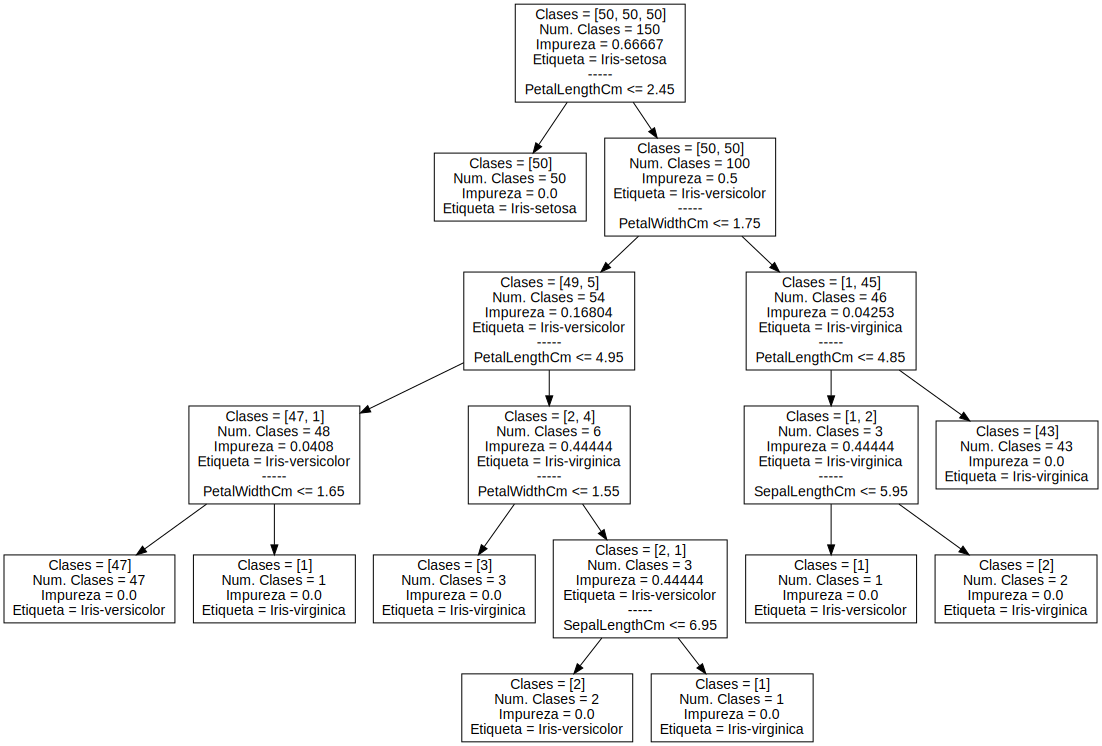

In [245]:
def graficarArbol(arbol,funcImp = funcImpGini):
    tree = graphviz.Digraph(comment='Arbol de Decisión')
    def atributosAtexto(arbol,terminal = 0):
      lista = [str("Clases = ") +str(arbol.data.iloc[:,-1].value_counts(sort=False).to_list()),
               str("Num. Clases = ") +str(sum(arbol.data.iloc[:,-1].value_counts(sort=False).to_list())),
               str("Impureza = ")+str(np.round(funcImp(arbol.data),5)),
               str("Etiqueta = ")+str(arbol.etiqueta),
               str("-----"),
               str(arbol.mejor_variable)+str(" <= ")+str(arbol.threshold)]
      if terminal == 1:
        lista2 = lista[:-2]
        return '\n'.join(lista2)
      else:
        return '\n'.join(lista)
    def marcar_hojas(nodo,eti = "raiz"):
      strizq = eti + "-" + "izq"
      strder = eti + "-" + "der"
      if nodo.estadoNodo == None:
        tree.node(eti, atributosAtexto(nodo),shape='box',fontname="Arial")
        marcar_hojas(nodo.hoja_izq,strizq)
        marcar_hojas(nodo.hoja_der,strder)
        tree.edge(eti, strizq)
        tree.edge(eti, strder)

      elif nodo.estadoNodo != "Terminal":
        tree.node(eti, atributosAtexto(nodo),shape='box',fontname="Arial")
        marcar_hojas(nodo.hoja_izq,eti)
        marcar_hojas(nodo.hoja_der,eti)
      else:
        tree.node(eti, atributosAtexto(nodo, terminal = 1),shape='box',fontname="Arial")
    marcar_hojas(arbol)
    return graphviz.Source(tree)

graficarArbol(primer_arbol)

Se procederá a podar el árbol. No obstante, se deben crear las funciones del costo de error de clasificación. Entonces

In [194]:
def costo_claserror_nodo(nodo):
    datos = nodo.data
    prop = [1-Fraction(i,datos.shape[0]) for i in datos.iloc[:,-1].value_counts()]
    return min(prop)

def R_costo_claserror_nodo(nodo, alpha = 0):
  r_t = (costo_claserror_nodo(nodo))*(Fraction(nodo.data.shape[0],datos.shape[0]))
  return r_t + alpha

def R_costo_claserror_arbol(arbol, alpha = 0):
  contador = 0
  def _costo_arbol(arbol):
    nonlocal contador
    el_arbol = arbol
    if el_arbol.estadoNodo != "Terminal":
      _costo_arbol(el_arbol.hoja_izq)
      _costo_arbol(el_arbol.hoja_der)
    else:
      contador += R_costo_claserror_nodo(el_arbol)
    return contador
  return _costo_arbol(arbol) + alpha*num_hojas(arbol)

def num_hojas(arbol,k=0):
  k = 0
  def _contador(arbol):
    nonlocal k
    if arbol is None:
      return None
    _contador(arbol.hoja_izq)
    _contador(arbol.hoja_der)
    if arbol.estadoNodo == "Terminal":
      k += 1
  _contador(arbol)
  return k


Con lo anterior se puede formar el árbol $T(0)$ el cual consiste en eliminar los nodos $t$ tal que sus sub-nodos $t_L,t_R$ cumplan $$R(t)=R(t_L)+R(t_R)$$
Dando como resultado el siguiente código, no obstante este código puede recibir un $\alpha$ cualquiera, por defecto es $\alpha = 0$

In [232]:
def podado_alpha(alpha = 0):
    _arbol = primer_arbol
    def _podado(arbol):
      nonlocal alpha
      switch = False
      lista_marcados = []
      def marcar_nodos(arbol):
        nonlocal alpha, lista_marcados, switch
        if arbol.estadoNodo == "Terminal":
          pass
        else:
          marcar_nodos(arbol.hoja_izq)
          marcar_nodos(arbol.hoja_der)
          R_arbol = R_costo_claserror_arbol(arbol,alpha)
          R_nodo = R_costo_claserror_nodo(arbol,alpha)
          if R_arbol >= R_nodo:
            switch = True
            lista_marcados.append((arbol.mejor_variable,arbol.threshold))
      marcar_nodos(arbol)
      def _cortar(arbol):
        nonlocal lista_marcados
        if arbol.estadoNodo == "Terminal":
          return nodo(mejor_variable = arbol.mejor_variable,
                    threshold = arbol.threshold,
                    hoja_izq = arbol.hoja_izq,
                    hoja_der = arbol.hoja_der,
                    etiqueta = arbol.etiqueta,
                    impureza = arbol.impureza,
                    estadoNodo = arbol.estadoNodo,
                    data = arbol.data)
        else:
          if (arbol.mejor_variable,arbol.threshold) in lista_marcados:
            return nodo(mejor_variable = arbol.mejor_variable,
                    threshold = arbol.threshold,
                    hoja_izq = None,
                    hoja_der = None,
                    etiqueta = arbol.etiqueta,
                    impureza = arbol.impureza,
                    estadoNodo = "Terminal",
                    data = arbol.data)
          else:
            h_i = _cortar(arbol.hoja_izq)
            h_d = _cortar(arbol.hoja_der)
            return nodo(mejor_variable = arbol.mejor_variable,
                    threshold = arbol.threshold,
                    hoja_izq = h_i,
                    hoja_der = h_d,
                    etiqueta = arbol.etiqueta,
                    impureza = arbol.impureza,
                    estadoNodo = arbol.estadoNodo,
                    data = arbol.data)
      if switch is True:
        return _podado(_cortar(arbol))      
      else:        
        return _cortar(arbol)
    return _podado(_arbol)

Basados en el anterior código, la siguiente función nos da como resultado los alfas asociados a los nodos debiles y además, los árboles formados con estos:

In [236]:
def podado_minimos():
  arbol = podado_alpha()
  listaMin,listaArboles = [0],[arbol]
  g1 = lambda nodo : Fraction(R_costo_claserror_nodo(nodo) - R_costo_claserror_arbol(nodo) , (num_hojas(nodo) - 1))
  def _podado(arbol):
    nonlocal listaMin,listaArboles
    min = float("Inf")
    def buscar_valor_min(arbol):
      nonlocal min
      if arbol.estadoNodo == "Terminal":
        pass
      else:
        buscar_valor_min(arbol.hoja_izq)
        buscar_valor_min(arbol.hoja_der)
        weak_score = g1(arbol)
        if weak_score < min:
          min = weak_score
    buscar_valor_min(arbol)
    listaMin.append(min)
    def _cortar(arbol):
      nonlocal min
      if arbol.estadoNodo == "Terminal":
        return nodo(mejor_variable = arbol.mejor_variable,
                  threshold = arbol.threshold,
                  hoja_izq = arbol.hoja_izq,
                  hoja_der = arbol.hoja_der,
                  etiqueta = arbol.etiqueta,
                  impureza = arbol.impureza,
                  estadoNodo = arbol.estadoNodo,
                  data = arbol.data)
      else:
        if g1(arbol) == min:
          return nodo(mejor_variable = arbol.mejor_variable,
                  threshold = arbol.threshold,
                  hoja_izq = None,
                  hoja_der = None,
                  etiqueta = arbol.etiqueta,
                  impureza = arbol.impureza,
                  estadoNodo = "Terminal",
                  data = arbol.data)
        else:
          h_i = _cortar(arbol.hoja_izq)
          h_d = _cortar(arbol.hoja_der)
          return nodo(mejor_variable = arbol.mejor_variable,
                  threshold = arbol.threshold,
                  hoja_izq = h_i,
                  hoja_der = h_d,
                  etiqueta = arbol.etiqueta,
                  impureza = arbol.impureza,
                  estadoNodo = arbol.estadoNodo,
                  data = arbol.data)
    listaArboles.append(_cortar(arbol))
    if num_hojas(arbol) > 2:
      return _podado(_cortar(arbol))

  _podado(arbol)
  return listaMin,listaArboles

Alfas de nodos de enlace débil:  [0, Fraction(1, 300), Fraction(1, 150), Fraction(1, 75), Fraction(22, 75), Fraction(1, 3)]
Gráfica del árbol asociado a alfa = 1/75


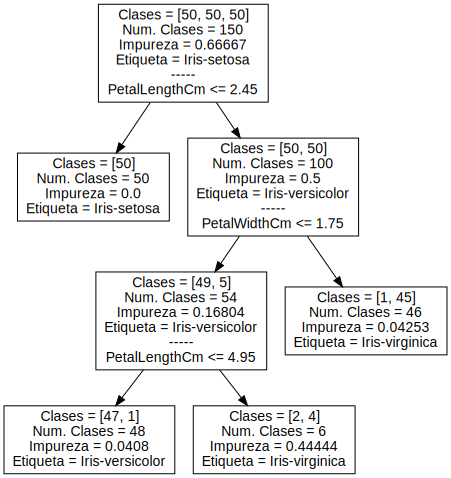

In [251]:
alfas,arboles = podado_minimos()
print("Alfas de nodos de enlace débil: ",alfas)
print("Gráfica del árbol asociado a alfa = 1/75")
graficarArbol(arboles[2])

Los anteriores códigos muestran como generar árboles de clasificación. Sin embargo, si usted quiere probar con su propia base de datos, puede copiar y pegar el siguiente código en un Colab de Google (como este):

In [267]:
import pandas as pd 
import numpy as np  
from fractions import Fraction 
import graphviz # Ayuda a graficar los árboles
class arbolClasificacion:
  class nodo:
    def __init__(
        self,mejor_variable = None,
        threshold = None,
        hoja_izq = None,
        hoja_der = None,
        etiqueta = None,
        impureza = None,
        estadoNodo = None,
        data = None):
      self.mejor_variable = mejor_variable  #Guarda la mejor variable juzgada por la función de disminución de impureza
      self.threshold = threshold            #Guarda el mejor umbral de la variable por la función de disminución de impureza
      self.hoja_izq = hoja_izq              #Guarda el nodo izquierdo resultado de una división
      self.hoja_der = hoja_der              #Guarda el nodo derecho resultado de una división
      self.etiqueta = etiqueta              #Guarda la clase representante del nodo (tomando la clase de mayor proporción)
      self.impureza = impureza              #Guarda la reducción de la impureza de la variable y el umbral.
      self.estadoNodo = estadoNodo          #Guarda el estado del nodo (hoja, no terminal)
      self.data = data                      #Guarda un dataframe con los datos que residen en el nodo
      
  def __init__(
    self,max_prof = "max",
    func_Imp = "gini",
    num_variables = "todas",
    min_div = 2):

    self.max_prof = max_prof
    if func_Imp == "gini":
      self.func_Imp = self.funcImpGini
    elif func_Imp == "entropia":
      self.func_Imp = self.funcImpEntropia

  def funcImpGini(self,datos) -> float:
    y = datos[datos.columns[-1]]
    proporciones = y.value_counts(normalize=True)
    suma = 0
    for i in proporciones:
      suma += i**2
    return 1-suma

  def funcImpEntropia(self,datos) -> float:
    y = datos[datos.columns[-1]]
    proporciones = y.value_counts(normalize=True)
    suma = 0
    for i in proporciones:
      if i == 0:
        continue
      else:
        suma += i*np.log2(i)
    return -suma
  
  def funcReducImp(self,nodo,nodo_izq,nodo_der) -> float: 
    tamano_nodo, tamano_nodo_izq, tamano_nodo_der = nodo.shape[0],nodo_izq.shape[0],nodo_der.shape[0]
    impureza_nodo = self.func_Imp(nodo)
    impureza_nodo_izq, impureza_nodo_der = self.func_Imp(nodo_izq), self.func_Imp(nodo_der)
    prop_nodo_izq, prop_nodo_der = tamano_nodo_izq / tamano_nodo, tamano_nodo_der / tamano_nodo
    return impureza_nodo - prop_nodo_izq * impureza_nodo_izq - prop_nodo_der * impureza_nodo_der
  
  def mejor_variable_nodo(self,datos):
    dicMejor = {} #Aqui se guarda la información de la mejor_variable
    max = 0  # Se toma un valor base
    nombre_variables = datos.columns[:-1]
    for variable in nombre_variables:
        datos_variable = datos[variable]
        datos_unicos_variable = np.unique(datos_variable) #la función toma los datos únicos y los organiza de menor a mayor
        if datos_variable.dtype.kind in 'iufc': #En caso de que la variable sea numérica o booleana
            puntos_medios = [(datos_unicos_variable[i]+datos_unicos_variable[i+1])/2 for i in range(len(datos_unicos_variable)-1)] #Se toman los puntos medios
            for punto in puntos_medios:
                nodo_izq, nodo_der = datos[datos_variable <= punto], datos[datos_variable > punto]
                redImpureza = self.funcReducImp(datos,nodo_izq,nodo_der)
                if redImpureza > max:
                    max = redImpureza
                    threshold = punto
                    nombre_mejorVariable = variable
                    hoja_izq = nodo_izq
                    hoja_der = nodo_der
        else: #En caso de que la variable sea cualitativa
            for cualidad in datos_unicos_variable:
                nodo_izq, nodo_der = datos[datos_variable == cualidad], datos[datos_variable != cualidad]
                redImpureza = self.funcReducImp(datos,nodo_izq,nodo_der)
                if redImpureza > max:
                    max = redImpureza
                    threshold = cualidad
                    nombre_mejorVariable = variable
                    hoja_izq = nodo_izq
                    hoja_der = nodo_der
    dicMejor["Variable"] = nombre_mejorVariable
    dicMejor["Threshold"] = threshold
    dicMejor["valorImpureza"] = max
    dicMejor["nodoIzq"] = hoja_izq
    dicMejor["nodoDer"] = hoja_der
    return dicMejor

  def crear_arbol(self,datos,k = 0): #k representa el nivel del nodo en un grafo, k=0 es la raíz (nivel 0)
      datos_unicos = datos.drop_duplicates(subset = datos.columns[:-1])
      max_etiquetas_unicas = max(datos.iloc[:,-1].value_counts())
      num_datos = datos_unicos.shape[0]
      etiqueta_nodo = datos.iloc[:,-1].mode()[0]
      if num_datos > 1 and max_etiquetas_unicas != datos.shape[0]:
        mejor_div_data = self.mejor_variable_nodo(datos)
        mejorVariable = mejor_div_data["Variable"]
        mejorThreshold = mejor_div_data["Threshold"]  
        subarbol_izq = self.crear_arbol(mejor_div_data["nodoIzq"],k+1)
        subarbol_der = self.crear_arbol(mejor_div_data["nodoDer"],k+1)
        return self.nodo(mejor_variable=mejorVariable,
                        threshold=mejorThreshold,
                        hoja_izq = subarbol_izq,
                        hoja_der = subarbol_der,
                        etiqueta = etiqueta_nodo,
                        impureza = mejor_div_data["valorImpureza"],
                        data = datos)
      return self.nodo(etiqueta = etiqueta_nodo, impureza = self.func_Imp(datos), estadoNodo = "Terminal", data = datos)
    
  def costo_claserror_nodo(self,nodo):
    datos = nodo.data
    prop = [1-Fraction(i,nodo.data.shape[0]) for i in datos.iloc[:,-1].value_counts()]
    return min(prop)

  def R_costo_claserror_nodo(self,nodo, alpha = 0):
    r_t = (self.costo_claserror_nodo(nodo))*(Fraction(nodo.data.shape[0],self.prop))
    return r_t + alpha

  def R_costo_claserror_arbol(self,arbol, alpha = 0):
    contador = 0
    def _costo_arbol(arbol):
      nonlocal contador
      el_arbol = arbol
      if el_arbol.estadoNodo != "Terminal":
        _costo_arbol(el_arbol.hoja_izq)
        _costo_arbol(el_arbol.hoja_der)
      else:
        contador += self.R_costo_claserror_nodo(el_arbol)
      return contador
    return _costo_arbol(arbol) + alpha*self.num_hojas(arbol)
  
  def num_hojas(self,arbol)-> int:
    contador = 0
    def _num_hojas(arbol):
      nonlocal contador
      el_arbol = arbol
      if el_arbol.estadoNodo != "Terminal":
        _num_hojas(el_arbol.hoja_izq)
        _num_hojas(el_arbol.hoja_der)
      else:
        contador += 1
      return contador
    return _num_hojas(arbol)
  
  def podado_minimos(self):
    arbol = self.podado_alpha()
    listaMin,listaArboles = [0],[arbol]
    g1 = lambda nodo : Fraction(self.R_costo_claserror_nodo(nodo) - self.R_costo_claserror_arbol(nodo) , (self.num_hojas(nodo) - 1))
    def _podado(arbol):
      nonlocal listaMin,listaArboles
      min = float("Inf")
      def buscar_valor_min(arbol):
        nonlocal min
        if arbol.estadoNodo == "Terminal":
          pass
        else:
          buscar_valor_min(arbol.hoja_izq)
          buscar_valor_min(arbol.hoja_der)
          weak_score = g1(arbol)
          if weak_score < min:
            min = weak_score
      buscar_valor_min(arbol)
      listaMin.append(min)
      def _cortar(arbol):
        nonlocal min
        if arbol.estadoNodo == "Terminal":
          return self.nodo(mejor_variable = arbol.mejor_variable,
                    threshold = arbol.threshold,
                    hoja_izq = arbol.hoja_izq,
                    hoja_der = arbol.hoja_der,
                    etiqueta = arbol.etiqueta,
                    impureza = arbol.impureza,
                    estadoNodo = arbol.estadoNodo,
                    data = arbol.data)
        else:
          if g1(arbol) == min:
            return self.nodo(mejor_variable = arbol.mejor_variable,
                    threshold = arbol.threshold,
                    hoja_izq = None,
                    hoja_der = None,
                    etiqueta = arbol.etiqueta,
                    impureza = arbol.impureza,
                    estadoNodo = "Terminal",
                    data = arbol.data)
          else:
            h_i = _cortar(arbol.hoja_izq)
            h_d = _cortar(arbol.hoja_der)
            return self.nodo(mejor_variable = arbol.mejor_variable,
                    threshold = arbol.threshold,
                    hoja_izq = h_i,
                    hoja_der = h_d,
                    etiqueta = arbol.etiqueta,
                    impureza = arbol.impureza,
                    estadoNodo = arbol.estadoNodo,
                    data = arbol.data)
      listaArboles.append(_cortar(arbol))
      if self.num_hojas(arbol) > 2:
        return _podado(_cortar(arbol))

    _podado(arbol)
    return listaMin,listaArboles
  
  def podado_alpha(self,alpha = 0):
    _arbol = self.arbol
    def _podado(arbol):
      nonlocal alpha
      switch = False
      lista_marcados = None
      def marcar_nodos(arbol):
        nonlocal alpha, lista_marcados, switch
        if arbol.estadoNodo == "Terminal":
          pass
        else:
          marcar_nodos(arbol.hoja_izq)
          marcar_nodos(arbol.hoja_der)
          R_arbol = self.R_costo_claserror_arbol(arbol,alpha)
          R_nodo = self.R_costo_claserror_nodo(arbol,alpha)
          #print(arbol.mejor_variable,arbol.threshold,R_arbol,R_nodo)
          if switch is True:
            pass
          elif R_arbol >= R_nodo:
            switch = True
            lista_marcados = (arbol.mejor_variable,arbol.threshold)
      marcar_nodos(arbol)
      def _cortar(arbol):
        nonlocal lista_marcados
        if arbol.estadoNodo == "Terminal":
          return self.nodo(mejor_variable = arbol.mejor_variable,
                    threshold = arbol.threshold,
                    hoja_izq = arbol.hoja_izq,
                    hoja_der = arbol.hoja_der,
                    etiqueta = arbol.etiqueta,
                    impureza = arbol.impureza,
                    estadoNodo = arbol.estadoNodo,
                    data = arbol.data)
        else:
          if (arbol.mejor_variable,arbol.threshold) == lista_marcados:
            return self.nodo(mejor_variable = arbol.mejor_variable,
                    threshold = arbol.threshold,
                    hoja_izq = None,
                    hoja_der = None,
                    etiqueta = arbol.etiqueta,
                    impureza = arbol.impureza,
                    estadoNodo = "Terminal",
                    data = arbol.data)
          else:
            h_i = _cortar(arbol.hoja_izq)
            h_d = _cortar(arbol.hoja_der)
            return self.nodo(mejor_variable = arbol.mejor_variable,
                    threshold = arbol.threshold,
                    hoja_izq = h_i,
                    hoja_der = h_d,
                    etiqueta = arbol.etiqueta,
                    impureza = arbol.impureza,
                    estadoNodo = arbol.estadoNodo,
                    data = arbol.data)
      if switch is True:
        return _podado(_cortar(arbol))      
      else:        
        return _cortar(arbol)
    return _podado(_arbol)

  def fit (self,X,y):
    X_copia = X.copy()
    datos = pd.concat([X_copia, y], axis=1)
    self.nombre_columnas = datos.columns
    self.prop = datos.shape[0]
    self.arbol = self.crear_arbol(datos)
    
  def _predict(self,datos,arbol):
    def _converir_formato_numpy2pd(dato):
      pandas = pd.DataFrame([dato], columns = self.nombre_columnas[:-1])
      return pandas
    def _evaluarenArbol(dato,arbol):
      if arbol.estadoNodo == "Terminal": return arbol.etiqueta
      else:
        variable = arbol.mejor_variable
        threshold = arbol.threshold
        if (dato[variable] <= threshold).bool() is True:
          return _evaluarenArbol(dato,arbol.hoja_izq)
        else:
          return _evaluarenArbol(dato,arbol.hoja_der)
    if isinstance(datos,pd.DataFrame):
      data_res = [_evaluarenArbol(_converir_formato_numpy2pd(i),arbol) for i in datos.to_numpy()]
    else:
      data_res = [_evaluarenArbol(_converir_formato_numpy2pd(i),arbol) for i in datos]
    return data_res

  def predict(self,datos):
    return self._predict(datos,clf.arbol)

  def graficarArbol(self,arbol):
    tree = graphviz.Digraph(comment='Arbol de Decisión')
    def atributosAtexto(arbol,terminal = 0):
      lista = [str("Clases = ") +str(arbol.data.iloc[:,-1].value_counts(sort=False).to_list()),
               str("Num. Clases = ") +str(sum(arbol.data.iloc[:,-1].value_counts(sort=False).to_list())),
               str("Impureza = ")+str(np.round(self.func_Imp(arbol.data),5)),
               str("Etiqueta = ")+str(arbol.etiqueta),
               str("-----"),
               str(arbol.mejor_variable)+str(" <= ")+str(arbol.threshold)]
      if terminal == 1:
        lista2 = lista[:-2]
        return '\n'.join(lista2)
      else:
        return '\n'.join(lista)
    def marcar_hojas(nodo,eti = "raiz"):
      strizq = eti + "-" + "izq"
      strder = eti + "-" + "der"
      if nodo.estadoNodo == None:
        tree.node(eti, atributosAtexto(nodo),shape='box',fontname="Arial")
        marcar_hojas(nodo.hoja_izq,strizq)
        marcar_hojas(nodo.hoja_der,strder)
        tree.edge(eti, strizq)
        tree.edge(eti, strder)

      elif nodo.estadoNodo != "Terminal":
        tree.node(eti, atributosAtexto(nodo),shape='box',fontname="Arial")
        marcar_hojas(nodo.hoja_izq,eti)
        marcar_hojas(nodo.hoja_der,eti)
      else:
        tree.node(eti, atributosAtexto(nodo, terminal = 1),shape='box',fontname="Arial")
    marcar_hojas(arbol)
    return graphviz.Source(tree)


Ahora bien, para usar el anterior código primero defina el conjunto $X$ de variables independientes, y el conjunto $y$ de la variable dependiente. Entonces:

In [277]:
X = datos.iloc[:,:-1]
y = datos.iloc[:,-1]
#Para nuestro caso se tomará una muestra de aprendizaje y de prueba que puede ser generada con el siguiente codigo:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
96,5.7,2.9,4.2,1.3
105,7.6,3.0,6.6,2.1
66,5.6,3.0,4.5,1.5
0,5.1,3.5,1.4,0.2
122,7.7,2.8,6.7,2.0


Ahora bien, ejecute el siguiente código

In [278]:
clf = arbolClasificacion()
clf.fit(X_train,y_train)

El árbol ha sido creado, si usted lo quiere visualizar, puede usar la función creada anteriormente:

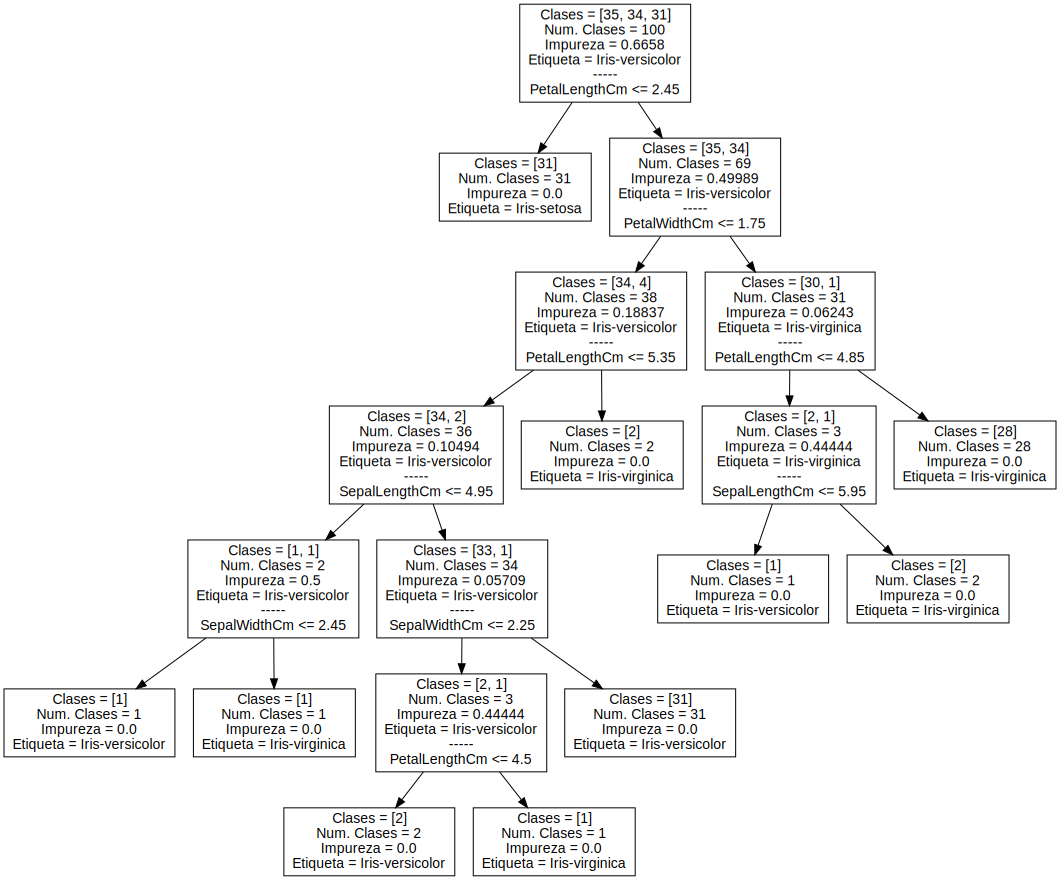

In [279]:
clf.graficarArbol(clf.arbol)

Ahora bien, para observar los árboles podados, ejecute el siguiente código:

In [280]:
alfas, arboles = clf.podado_minimos()
print("Los alfas asociados a los nodos de enlace débil son: ",alfas)
print("Los arboles están en una lista: ")
arboles

Los alfas asociados a los nodos de enlace débil son:  [0, Fraction(1, 200), Fraction(1, 50), Fraction(29, 100), Fraction(31, 100)]
Los arboles están en una lista: 


Para observar la gráfica de algún arbol de la lista "arboles" ejecute el siguiente código:

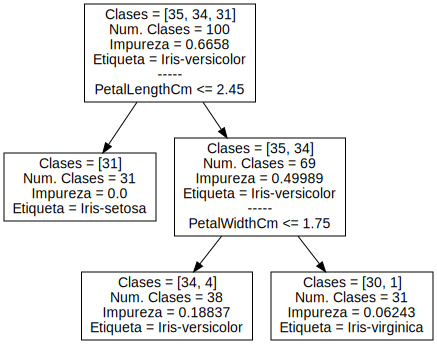

In [281]:
clf.graficarArbol(arboles[2]) #Evalua el árbol 2 de la lista

Para predecir nuevos datos puede ejecutar el siguiente código:

In [289]:
#Si quiere predecir para el árbol extendido al máximo:
pred_arbolmax = clf.predict(X_train)
#Si quiere predecir con los árboles podados:
pred_arbol2 = clf._predict(X_train,arboles[2])

Ahora bien, se observará el rendimiento de los árboles podados:

In [291]:
from sklearn.metrics import accuracy_score
for i in range(len(arboles)):
  y_pred = clf._predict(X_test,arboles[i])
  print("Precisión del árbol con alfa = ",alfas[i],": ",accuracy_score(y_test, y_pred))

Precisión del árbol con alfa =  0 :  0.98
Precisión del árbol con alfa =  1/200 :  0.98
Precisión del árbol con alfa =  1/50 :  0.98
Precisión del árbol con alfa =  29/100 :  0.68
Precisión del árbol con alfa =  31/100 :  0.3
